# Basic Linear Triangulation 

The goal of this section is to understand the geometric relationships between multiple views of a scene. Linear triangulation is a fundamental step in 3D reconstruction pipelines. It involves estimating the 3D coordinates of points in a scene using projections onto two or more images taken from different camera perspectives. This process is essential because it allows us to map the 2D image features into the 3D world, providing a foundation for building more detailed 3D models.

In this notebook you will:
1. Pre-process the dataset and extract key features from the images using feature detection methods such as **SIFT** or **ORB**.
2. Match these features across image pairs to identify corresponding points.
3. Compute the fundamental and essential matrices to estimate the relative poses of the cameras.
4. Use linear triangulation to determine the 3D coordinates of a point in space and visualize it.

#### Imports

In [15]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
import os

### Dataset
We will use the [Heritage-Recon](https://drive.google.com/drive/folders/1eZvmk4GQkrRKUNZpagZEIY_z8Lsdw94v) dataset, which contains sets of images of various landmarks captured from multiple angles. You can choose one landmark for your project and use its dataset for this task.

If you go through the dataset, you will find the images for your landmark in the **dense/images** folder. There are also some other important files that you will see. For example, the root directory of the brandenburg gate dataset contains the **brandenburg_gate.ply**, which is the actual 3D model generated from the dataset. You will generating something similar for the next deliverable as well.

The **neuralsfm** folder contains three key **.bin** files, which are binary files commonly used in Structure from Motion (SfM) pipelines like COLMAP for storing 3D reconstruction data:
1. cameras.bin: stores information about the cameras used in the SfM process. It includes intrinsic parameters, such as focal lengths and principal points, as well as extrinsic parameters that define the camera's position and orientation.
2. images.bin: contains the images’ pose information within the 3D space. It also includes 2D keypoints detected in each image and their associations with 3D points. This file is crucial for understanding where each image is located in the reconstructed scene.
3. points3D.bin: holds information about the reconstructed 3D points, including their 3D coordinates, color, and visibility across images. It essentially represents the sparse point cloud of the scene, where each point correlates with specific 2D keypoints in the images.

The **semantic_maps** folder contains .npz files that store semantic segmentation data in a compressed format. Each .npz file corresponds to a semantic map or segmentation mask for a particular image, with classes or labels encoded as numerical values.

### Loading in our data

Load in 3 different images from the images folder and display them.

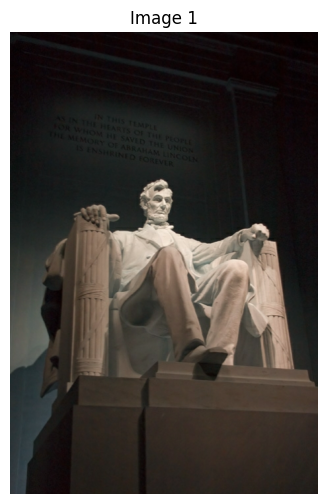

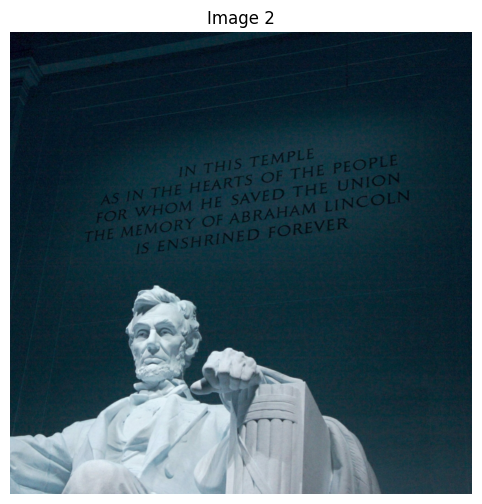

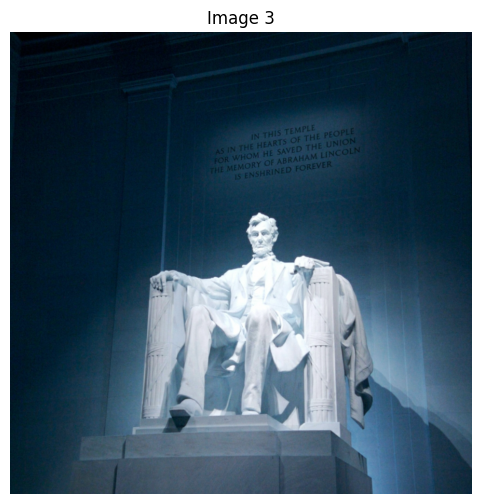

In [ ]:
# Using lincoln memorial images.
BASE_PATH = './lm'
BASE_IMAGES_PATH = os.path.join(BASE_PATH, 'lincoln_memorial/dense/images')
IMAGES_PATH = glob.glob(os.path.join(BASE_IMAGES_PATH, '*.jpg'))

for idx in range(3):
  plt.figure(figsize=(10,6))
  plt.imshow(cv2.imread(IMAGES_PATH[idx]))
  plt.title(f'Image {idx+1}')
  plt.axis('off')
  plt.show()

#### Pre-processing

If you go through the images in the dataset you will notice images with varying dimensions, angles, brightness levels etc. For us to effectively use our dataset, we first need to pre-process our images. Pre-processing ensures that the images are prepared consistently for feature detection, matching, and camera pose estimation.

Some helper functions that might be useful.

In [17]:
def get_img_paths(folder_pth):
    """Returns a list containing filenames of all jpg files in folder_pth"""
    jpg_files = []

    for filename in os.listdir(folder_pth):
        if filename.lower().endswith(".jpg"):
            # uncomment the line below if you want to include the entire path in the filename
            # filename = os.path.join(folder_pth, filename)
            jpg_files.append(filename)

    return jpg_files


def load_images(folder_pth):
    """Loads all images in folder_path"""
    images = []
    for filename in os.listdir(folder_pth):
        if filename.lower().endswith(".jpg"):
            img = cv2.imread(os.path.join(folder_pth, filename))
            images.append(img)

    return images


def resize_image(img, size=(800, 600)):
    """Resizes image to a specified size."""
    return cv2.resize(img, size)


def convert_to_grayscale(img):
    """Converts an image to grayscale."""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)



Now, load the images from the dataset folder, apply the pre-processing steps, and display few of the pre-processed images to verify. I have included a few types of pre-processing methods above, but you can use any other method as well that you believe might be helpful. Give a two-liner explaination for your pre-processing choices.

**Ans:** grayscale simplifies the data by reducing it to a single channel while retaining the structural information necessary for feature detection. While resizing ensures uniformity in input dimensions.

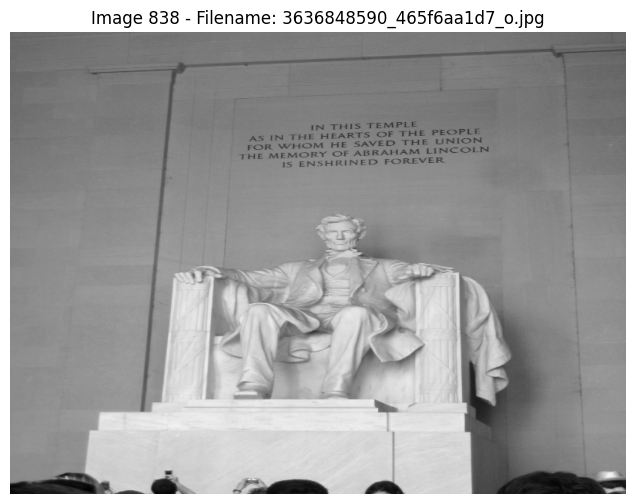

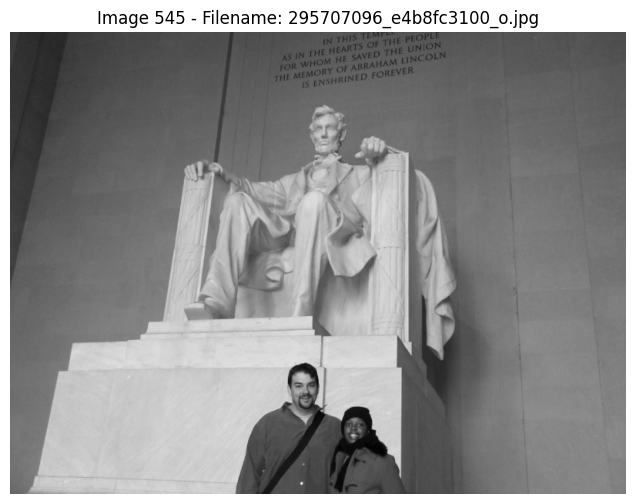

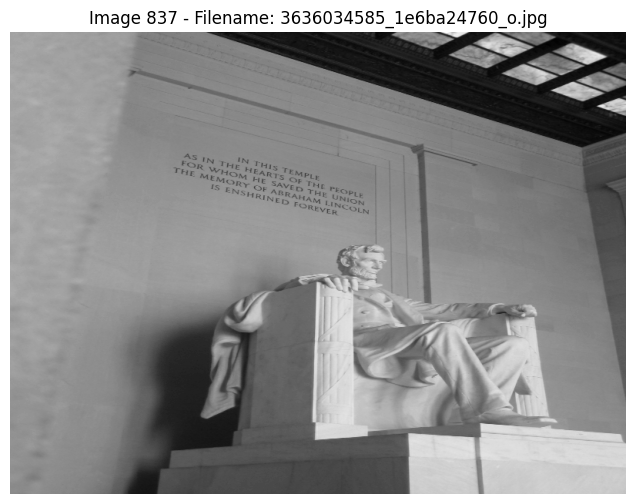

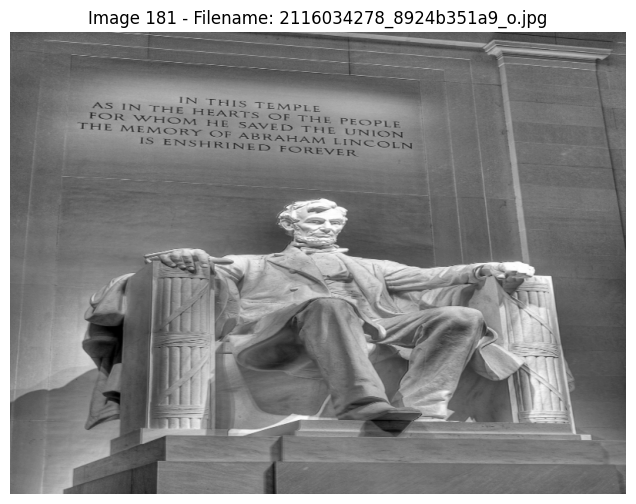

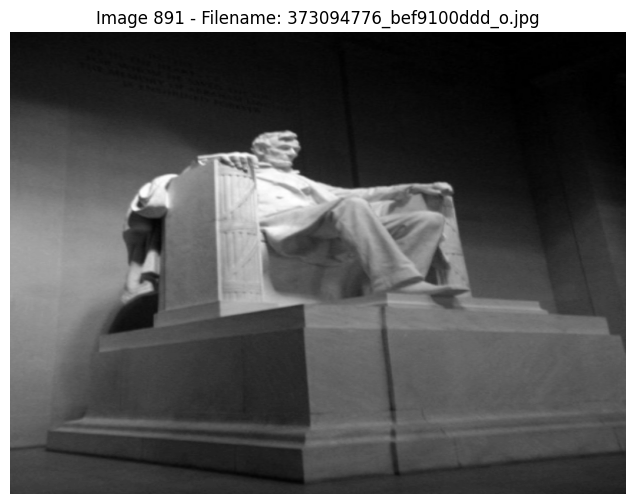

In [18]:
images_paths = get_img_paths(BASE_IMAGES_PATH)
images = load_images(BASE_IMAGES_PATH)
for idx, image in enumerate(images):
  images[idx] = convert_to_grayscale(resize_image(image))

for _ in range(5):
  random_idx = np.random.randint(0, len(images))
  plt.figure(figsize=(10,6))
  plt.imshow(images[random_idx], cmap='gray')
  plt.title(f'Image {random_idx+1} - Filename: {images_paths[random_idx]}')
  plt.axis('off')
  plt.show()

### Feature Detection

The goal is to identify distinct and robust points in the images that can be matched across different views. These feature points are the key to establishing correspondences between images.

There are several feature detection algorithms such as SIFT, SURF, or ORB available in the cv2 library. When using any of the algorithms, be sure to check the format of the image that it accepts.

Using any feature detection algorithm, extract the features from two images and display the images with the features higlighted on them. Here is an example:

<img src="assets/feature_detection.png" alt="My Image" width="800"/>

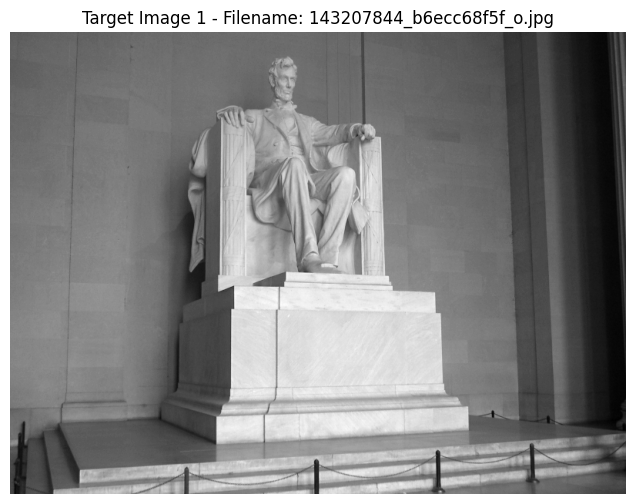

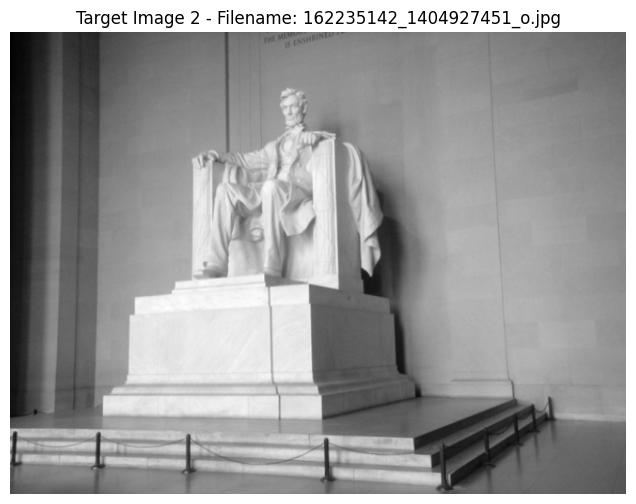

In [19]:
# Chosen images for reconstruction.
target_filenames = [ "143207844_b6ecc68f5f_o.jpg", "162235142_1404927451_o.jpg"]
target_indices = [idx for idx, path in enumerate(images_paths) if path.endswith(tuple(target_filenames))]
targets = [images[idx] for idx in target_indices]

for idx, target_image in enumerate(targets):
    plt.figure(figsize=(10, 6))
    plt.imshow(target_image, cmap='gray')
    plt.title(f"Target Image {idx+1} - Filename: {target_filenames[idx]}")
    plt.axis('off')
    plt.show()

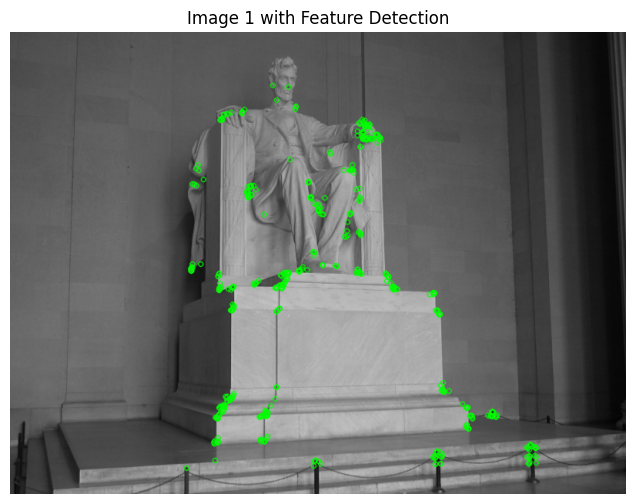

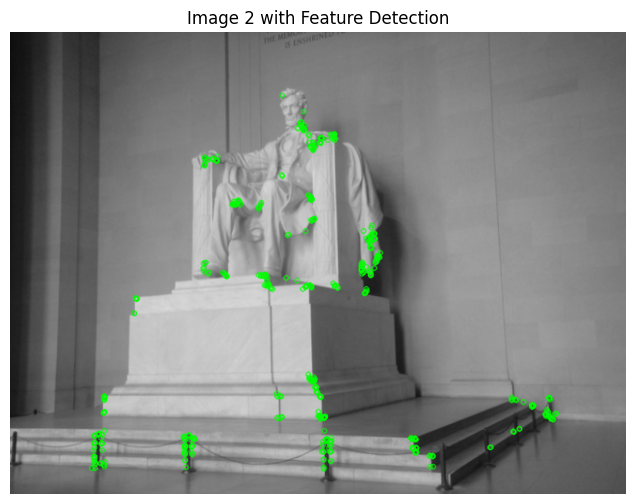

In [20]:
orb_detector = cv2.ORB_create()
fd_mapping = dict()

for idx, image in enumerate(targets):
    kpts, des = orb_detector.detectAndCompute(image, None)

    kpts_img = cv2.drawKeypoints(
        image,
        kpts,
        None,
        color=(0, 255, 0)
    )

    fd_mapping[idx] = (kpts, des, kpts_img)

for idx, (kpts, des, kpts_img) in fd_mapping.items():
    plt.figure(figsize=(10, 6))
    plt.imshow(kpts_img)
    plt.title(f'Image {idx+1} with Feature Detection')
    plt.axis('off')
    plt.show()

### Feature Matching

Feature matching is a crucial step in 3D reconstruction because it helps find corresponding points between different images. Once you've detected the keypoints and descriptors using a feature detector, the next step is to match these descriptors across pairs of images.


Use the keypoints and descriptors extracted above for the two images and match the features across the two images. You can use this as a reference image:

<img src="assets/feature_matching.png" alt="My Image" width="800"/>

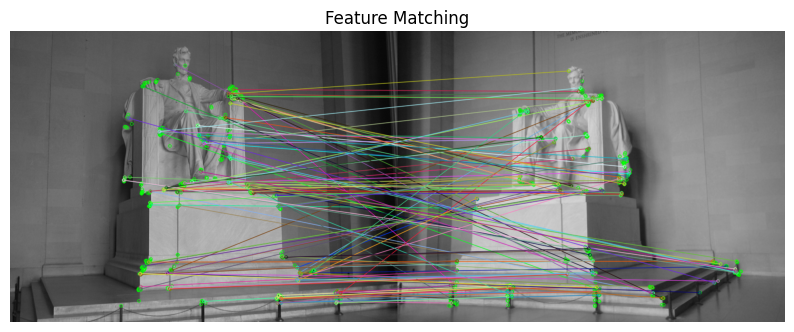

In [21]:
feature_detection_results = list(fd_mapping.values())
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(feature_detection_results[0][1], feature_detection_results[1][1])

matched_image = cv2.drawMatches(
    feature_detection_results[0][2], feature_detection_results[0][0], feature_detection_results[1][2], feature_detection_results[1][0], matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(10, 10))
plt.imshow(matched_image)
plt.title('Feature Matching')
plt.axis('off')
plt.show()


### Camera Pose Estimation

Camera pose estimation involves determining the relative position and orientation (i.e., rotation and translation) of the camera between two views. This is typically done by estimating the essential matrix or fundamental matrix between two sets of matched keypoints, and then decomposing these matrices to recover the camera pose.

So essentially:
1. Find the **fundamental matrix (F)** using the matched keypoints.
2. Decompose the **essential matrix (E)** into the rotation and translation components.
3. Use epipolar geometry to verify or refine the solution.

You can use the lecture slides as reference for computing these.

Calculate the fundemental and essential matrices. Use these to recover the translation and rotation matrices.

In [22]:
keypoints1, descriptors1, image1 = feature_detection_results[0]
keypoints2, descriptors2, image2 = feature_detection_results[1]

pts1 = np.array([keypoints1[m.queryIdx].pt for m in matches], dtype=np.float32)
pts2 = np.array([keypoints2[m.trainIdx].pt for m in matches], dtype=np.float32)

F, _ = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

print("Fundamental Matrix (F):\n", F)

K1 = np.array([
    [1808.905, 0, 800],
    [0,1808.063, 528],
    [0, 0, 1]
], dtype=np.float32)

K2 = np.array([
    [922.18, 0, 419.5],
    [0, 922.18 , 307],
    [0, 0, 1]
], dtype = np.float32)

E = K2.T @ F @ K1

print("\nEssential Matrix (E):\n", E)

_, R, T, _ = cv2.recoverPose(E=E, points2=pts2, points1=pts1, cameraMatrix=K1)

print("\nRotation Matrix (R):\n", R)
print("\nTranslation Vector (T):\n", T)

print("\nEpipolar Geometry Verification")
for i in range(5):
    pt1 = np.append(pts1[i], 1)  
    pt2 = np.append(pts2[i], 1)  

    epipolar_constraint = pt2.T @ F @ pt1
    print(f"Epipolar Constraint for point pair {i + 1}: {epipolar_constraint}")

Fundamental Matrix (F):
 [[-1.29453067e-07 -1.90070978e-07  1.86500019e-04]
 [ 3.89829272e-06  1.57081209e-06 -3.29911005e-03]
 [-2.01727716e-03  4.54685667e-04  1.00000000e+00]]

Essential Matrix (E):
 [[-0.21594532 -0.31691665 -0.01606429]
 [ 6.50288252  2.61910848  0.5984145 ]
 [-1.58244253  1.54985388 -0.18183909]]

Rotation Matrix (R):
 [[ 0.02145086  0.01268565  0.99968942]
 [-0.45962404  0.88811247 -0.00140739]
 [-0.88785449 -0.4594511   0.02488141]]

Translation Vector (T):
 [[-0.99282358]
 [-0.05836877]
 [-0.10437641]]

Epipolar Geometry Verification
Epipolar Constraint for point pair 1: -0.0017828068343997971
Epipolar Constraint for point pair 2: 0.17907216886452482
Epipolar Constraint for point pair 3: -0.04972836960052418
Epipolar Constraint for point pair 4: 0.19105765088585236
Epipolar Constraint for point pair 5: -0.008506106907259725


### Linear Triangulation

Linear triangulation involves determining the 3D coordinates of a point in space based on its projections in two or more images taken from different viewpoints. Given two camera poses and the corresponding 2D feature points in both images, linear triangulation allows you to estimate the 3D coordinates of the points in the scene.

Compute the 3D coordinates of the matched feature points by solving the system of equations derived from the camera projection equations above.

In [26]:
P1 = K1 @ np.hstack((np.eye(3), np.zeros((3, 1))))  
P2 = K2 @ np.hstack((R, T))  

print("Projection Matrix P1:\n", P1)
print("\nProjection Matrix P2:\n", P2)

points_4d_hom = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)

points_3d = points_4d_hom[:3] / points_4d_hom[3]  
points_3d = points_3d.T

Projection Matrix P1:
 [[1.80890503e+03 0.00000000e+00 8.00000000e+02 0.00000000e+00]
 [0.00000000e+00 1.80806299e+03 5.28000000e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]

Projection Matrix P2:
 [[-3.52673402e+02 -1.81041284e+02  9.32331333e+02 -9.59347940e+02]
 [-6.96427422e+02  6.77948065e+02  6.34072818e+00 -8.58700710e+01]
 [-8.87854495e-01 -4.59451099e-01  2.48814100e-02 -1.04376406e-01]]


Visualise the 3D points obtained above. The results will probably not make any sense atm since we are only using two images, but this will help us in Task 2.

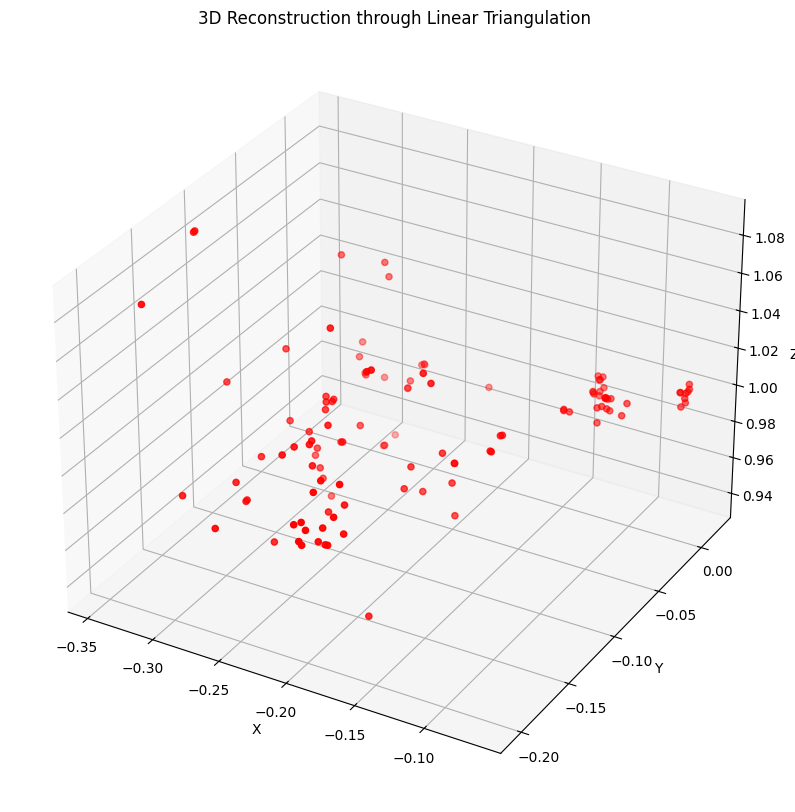

In [27]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c='r', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Reconstruction through Linear Triangulation')
plt.show()